# *Real Python* - "Primer on Python Decorators"

Joshua Cook

2020-04-05

This notebook is for my notes on the *Real Python* article on decorators: ["Primer on Python Decorators"](https://realpython.com/primer-on-python-decorators/).

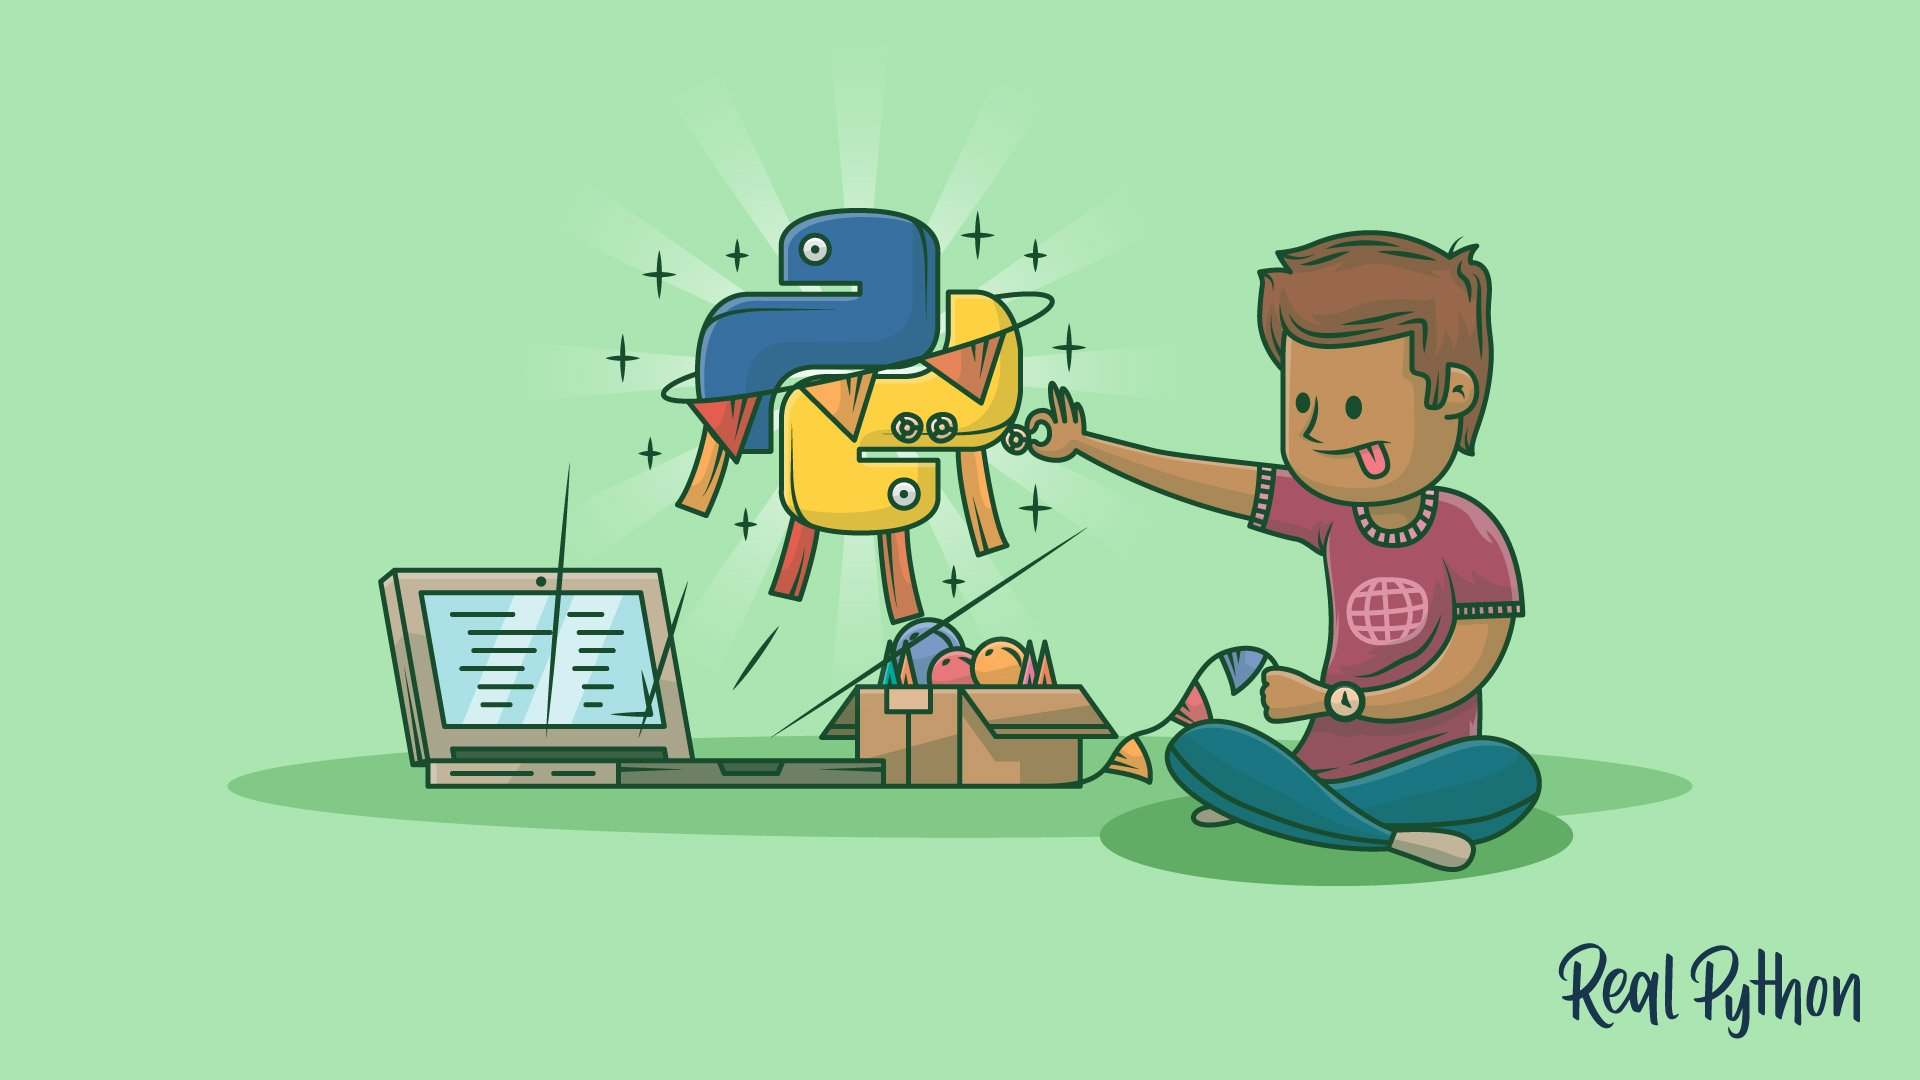

## Functions

In [1]:
def add_one(number):
    return number + 1

In [2]:
add_one(2)

3

In Python, functions are first-class objects, meaning they can be passed around as objects.

In [3]:
def say_hello(name):
    return f"Hello {name}"


def be_awesome(name):
    return f"Yo {name}, together we are the awesomest!"


def greet_bob(greeter_func):
    return greeter_func("Bob")

In [4]:
greet_bob(say_hello)

'Hello Bob'

In [5]:
greet_bob(be_awesome)

'Yo Bob, together we are the awesomest!'

### Inner functions

Functions can be defined within other functions.

### Returning functions from functions

In [6]:
def parent(num):
    def first_child():
        return "Hi, I am Emma."

    def second_child():
        return "Call me Liam."

    if num == 1:
        return first_child
    else:
        return second_child

In [7]:
parent(1)

<function __main__.parent.<locals>.first_child()>

In [8]:
parent(1)()

'Hi, I am Emma.'

## Simple decorators

In [9]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")

    return wrapper


def say_whee():
    print("Whee!")


say_whee = my_decorator(say_whee)

In [10]:
say_whee()

Something is happening before the function is called.
Whee!
Something is happening after the function is called.


### Syntactic sugar

Python allows the use of a decorator just by using the `@` symbol (called "pie" syntax).

In [11]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")

    return wrapper


@my_decorator
def say_whee():
    print("Whee!")

In [12]:
say_whee()

Something is happening before the function is called.
Whee!
Something is happening after the function is called.


### Reusing decorators

In [13]:
def do_twice(func):
    def wrapper_do_twice():
        func()
        func()

    return wrapper_do_twice

In [14]:
@do_twice
def say_whee():
    print("Whee!")

In [15]:
say_whee

<function __main__.do_twice.<locals>.wrapper_do_twice()>

In [16]:
say_whee()

Whee!
Whee!


### Decorating functions with arguments

In [17]:
def do_twice(func):
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        func(*args, **kwargs)

    return wrapper_do_twice

In [18]:
@do_twice
def greet(name):
    print(f"Hello, {name}")

In [19]:
greet("World")

Hello, World
Hello, World


### Returning values from decorated functions

In [20]:
def do_twice(func):
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        return func(*args, **kwargs)

    return wrapper_do_twice

In [21]:
@do_twice
def return_greeting(name):
    print("Creating greeting...")
    return f"Hello, {name}"

In [22]:
greeting = return_greeting("Adam")

Creating greeting...
Creating greeting...


In [23]:
greeting

'Hello, Adam'

### "Who are you, really?"

A functions decorated with the current iterations of the `do_twice()` decorator does not report the correct name when using introspection in Python.
If we look at `return_greeting()`, is reports it is a function named `wrapper_do_twice()`.

In [24]:
return_greeting

<function __main__.do_twice.<locals>.wrapper_do_twice(*args, **kwargs)>

In [25]:
return_greeting.__name__

'wrapper_do_twice'

This can be fixed by using the `@functools.wraps` decorator on the internal function of a decorator.

In [26]:
import functools


def do_twice(func):
    @functools.wraps(func)
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        return func(*args, **kwargs)

    return wrapper_do_twice

In [27]:
@do_twice
def return_greeting(name):
    print("Creating greeting...")
    return f"Hello, {name}"

In [28]:
return_greeting

<function __main__.return_greeting(name)>

In [29]:
return_greeting.__name__

'return_greeting'

## A few real-world examples

### Timing functions

In [30]:
import functools
import time


def timer(func):
    """Print the runtime of the decorated function."""

    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()

        value = func(*args, **kwargs)

        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")

        return value

    return wrapper_timer

In [31]:
@timer
def waste_some_time(num_times):
    for _ in range(num_times):
        sum([i ** 2 for i in range(10000)])

In [32]:
waste_some_time(1)

Finished 'waste_some_time' in 0.0087 secs


In [33]:
waste_some_time(1000)

Finished 'waste_some_time' in 4.7043 secs


### Debugging code

In [34]:
import functools


def debug(func):
    """Print the function signature and return value."""

    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]
        kwargs_repr = [f"{k}={v!r}" for kwargs, v in kwargs.items()]
        signature = ", ".join(args_repr + kwargs_repr)
        print(f"Calling {func.__name__}({signature})")

        value = func(*args, **kwargs)

        print(f"{func.__name__!r} returned {value!r}")
        return value

    return wrapper_debug

In [35]:
@debug
def make_greeting(name, age=None):
    if age is None:
        return f"Howdy {name}"
    else:
        return f"Whoa {name}! {age} already, you are growing up!"

In [36]:
make_greeting("Bob", 90)

Calling make_greeting('Bob', 90)
'make_greeting' returned 'Whoa Bob! 90 already, you are growing up!'


'Whoa Bob! 90 already, you are growing up!'

In [37]:
make_greeting("James")

Calling make_greeting('James')
'make_greeting' returned 'Howdy James'


'Howdy James'

### Registering plug-ins

Decorators can be used to create a light-weight plug-in architecture.

In [38]:
import random

PLUGINS = dict()


def register(func):
    """Register a function as a plug-in"""
    PLUGINS[func.__name__] = func
    return func

In [39]:
@register
def say_hello(name):
    return f"Hello {name}"


@register
def be_awesome(name):
    return f"Yo {name}, together we are the awesomest!"


def randomly_greet(name):
    greeter, greeter_func = random.choice(list(PLUGINS.items()))
    print(f"Using {greeter!r}")
    return greeter_func(name)

In [40]:
PLUGINS

{'say_hello': <function __main__.say_hello(name)>,
 'be_awesome': <function __main__.be_awesome(name)>}

## Fancy Decorators

### Decorating classes

There are two ways to use decorators with classes.
The first is to decorate class methods.
There are some build in decorators for methods including `@classmethod`, `@staticmethod`, and `@property`.
`@classmethod` and `@staticmethod` are used to define methods of a class that are not connected to a specific instance (object).
`@property` is used to create setters and getters.

In [41]:
class Circle:
    def __init__(self, radius):
        self._radius = radius

    @property
    def radius(self):
        """Get the value of the radius."""
        return self._radius

    @radius.setter
    def radius(self, value):
        """Set readius, raise and error if negative."""
        if value >= 0:
            self._radius = value
        else:
            raise ValueError("Radius must be positive.")

    @property
    def area(self):
        """Calculate the area of the circle."""
        return self.pi() * self.radius ** 2

    def cylinder_volume(self, height):
        """Calculate the volume of a cylinder with circle base."""
        return self.area * height

    @classmethod
    def unit_circle(cls):
        """Factory method create a circle with radius 1."""
        return cls(1)

    @staticmethod
    def pi():
        """Value of PI."""
        return 3.1415926535

In [42]:
c = Circle(5)
c.radius

5

In [43]:
c.area

78.5398163375

In [44]:
c.radius = 2
c.area

12.566370614

In [45]:
c.cylinder_volume(height=4)

50.265482456

In [46]:
try:
    c.radius = -2
except ValueError as err:
    print(err)

Radius must be positive.


In [47]:
Circle.unit_circle()

In [48]:
Circle.pi()

3.1415926535

In [49]:
c.pi()

3.1415926535

The other way to use decorators with classes is to decorate the entire class.
Below is an example using the new `@dataclass` decorator introduced in Python 3.7.
It can remove some of the boiler plate of creating a new class.

In [50]:
from dataclasses import dataclass


@dataclass
class PlayingCard:
    rank: str
    suit: str

In [51]:
card = PlayingCard(rank="Ace", suit="Club")
card.rank

'Ace'

A common use of class decorators is as a simpler alternative to metaclasses.

Writing a class decorator is similar to writing a function decorator, except it now accepts a class instead of a function.
This topic is revisited later in the tutorial.

### Nesting decorators

Several decorators can be applied at once by stacking them on top of each other.
Since the decorators are just functions order does matter with each decorator wrapping those below.
Effectively, the functions are nested bottom up.

In [52]:
@debug
@do_twice
def greet(name):
    print(f"Hello {name}")

In [53]:
greet("Eva")

Calling greet('Eva')
Hello Eva
Hello Eva
'greet' returned None


Note the difference if we swap the order.

In [54]:
@do_twice
@debug
def greet(name):
    print(f"Hello {name}")

In [55]:
greet("Eva")

Calling greet('Eva')
Hello Eva
'greet' returned None
Calling greet('Eva')
Hello Eva
'greet' returned None


The `@do_twice` decorator was applied to the `@debug` decorator, too.

### Decorators with arguments

Below is an example of a decorator that takes an argument.

In [56]:
def repeat(num_times):
    def decorator_repeat(func):
        @functools.wraps(func)
        def wrapper_repeat(*args, **kwargs):
            for _ in range(num_times):
                value = func(*args, **kwargs)
            return value

        return wrapper_repeat

    return decorator_repeat

The `repeat()` function returns a function `decorator_repeat()` which, in turn, returns the `wrapper_repeat()` function.
Because the decorator is called with parentheses, the first returned function, `decorator_repeat()` will be evaluated immediately, and the second function, `wrapper_repeat()` will still be used as the decorator for the function.
However, `wrapper_repeat()` is now in a closure where the variable `num_times` exists so it can use it to repeat the decorated function `num_times` times.

In [57]:
@repeat(num_times=4)
def greet(name):
    print(f"Hello {name}")

In [58]:
greet("World")

Hello World
Hello World
Hello World
Hello World


### Decorators with and without arguments

Since the function to decorate is only included as an argument when passed *without* arguments, it must be an optional argument and the first argument in the function call.
Consequently, all arguments must be specified with a keyword; this can be enforced using the special `*` syntax which forces all following arguments to be keyword-only.

Below is an outline of how these decorators are designed.

In [59]:
def name(_func=None, *, kw1, kw2):
    def decorator_name(func):
        # Create and return a wrapper function.
        x = 0

    if _func is None:
        return decorator_name
    else:
        return decorator_name(_func)

Here is this system used to rewrite the `@repeat` decorator.

In [60]:
def repeat(_func=None, *, num_times=2):
    def decorator_repeat(func):
        @functools.wraps(func)
        def wrapper_repeat(*args, **kwargs):
            for _ in range(num_times):
                value = func(*args, **kwargs)
            return value

        return wrapper_repeat

    if _func is None:
        return decorator_repeat
    else:
        return decorator_repeat(_func)

In [61]:
@repeat
def say_whee():
    print("Whee!")


@repeat(num_times=3)
def greet(name):
    print(f"Hello {name}")

In [62]:
say_whee()

Whee!
Whee!


In [63]:
greet("Bob")

Hello Bob
Hello Bob
Hello Bob


### Stateful decorators

In simple cases, a function decorator can be used to keep state.

In [64]:
def count_calls(func):
    @functools.wraps(func)
    def wrapper_count_calls(*args, **kwargs):
        wrapper_count_calls.num_calls += 1
        print(f"Call {wrapper_count_calls.num_calls} of {func.__name__!r}")
        return func(*args, **kwargs)

    wrapper_count_calls.num_calls = 0
    return wrapper_count_calls

In [65]:
@count_calls
def say_whee():
    print("Whee!")

In [66]:
for _ in range(5):
    say_whee()

Call 1 of 'say_whee'
Whee!
Call 2 of 'say_whee'
Whee!
Call 3 of 'say_whee'
Whee!
Call 4 of 'say_whee'
Whee!
Call 5 of 'say_whee'
Whee!


In [67]:
say_whee.num_calls

5

### Classes as decorators

The typical way to keep state in a decorator is to use a class instead of a function.
The only requirement is that the class conform to the *callable* protocol, meaning it has a `.__call__()` method.

In [68]:
class Counter:
    def __init__(self, func):
        functools.update_wrapper(self, func)
        self.func = func
        self.num_calls = 0

    def __call__(self, *args, **kwargs):
        self.num_calls += 1
        print(f"Current count is {self.num_calls}")
        return self.func(*args, **kwargs)

In [69]:
@Counter
def say_whee():
    print("Whee!")

In [70]:
for _ in range(5):
    say_whee()

Current count is 1
Whee!
Current count is 2
Whee!
Current count is 3
Whee!
Current count is 4
Whee!
Current count is 5
Whee!


In [71]:
say_whee.num_calls

5

## More real-world examples

### Creating singletons

The following `@singleton` decorator turns a class into a singleton by storing the first instance of the class as an attribute.
Later attempts as creating an instance just return the stored instance.

In [72]:
def singleton(cls):
    """Male a class a singleton class."""

    @functools.wraps(cls)
    def wrapper_singleton(*args, **kwargs):
        if not wrapper_singleton.instace:
            wrapper_singleton.instace = cls(*args, **kwargs)
        return wrapper_singleton.instace

    wrapper_singleton.instace = None
    return wrapper_singleton

In [73]:
@singleton
class TheOne:
    pass

In [74]:
first_one = TheOne()
second_one = TheOne()

first_one is second_one

True

### Memoisation

In [75]:
def memoise(func):
    """Memoise a function."""

    @functools.wraps(func)
    def wrapper_memoise(*args, **kwargs):
        cache_key = args + tuple(kwargs.items())
        if cache_key not in wrapper_memoise.cache:
            wrapper_memoise.cache[cache_key] = func(*args, **kwargs)
        return wrapper_memoise.cache[cache_key]

    wrapper_memoise.cache = dict()

    return wrapper_memoise

In [76]:
@timer
@memoise
def fibonacci(num):
    if num < 2:
        return num
    return fibonacci(num - 1) + fibonacci(num - 2)

In [77]:
fibonacci(10)

Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0001 secs
Finished 'fibonacci' in 0.0008 secs
Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0009 secs
Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0009 secs
Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0010 secs
Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0011 secs
Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0013 secs
Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0015 secs
Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0015 secs
Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0016 secs


55

In [78]:
fibonacci(10)

Finished 'fibonacci' in 0.0000 secs


55

In [79]:
fibonacci(11)

Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0000 secs
Finished 'fibonacci' in 0.0010 secs


89

(Note: In real code, just use the `@functools.lru_cache` decorator.)